In [ ]:
import os
output = 'opm_data.mat'  # Change the extension to .zip (or whatever the actual extension is)

# Only download if the file doesn't exist
if not os.path.exists(output):
    import gdown
    url = 'https://drive.google.com/uc?export=download&id=1ClOGtiwuy5UCdyPhaYTg2NZylUWaCQxP'
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} already exists, skipping download.")

In [1]:
import torch

class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import operator
from functools import reduce
from functools import partial
import numpy as np

torch.manual_seed(0)


In [3]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = 1 / (in_channels * out_channels)
        # Combining the weights into one tensor for easier handling
        self.weights = nn.Parameter(self.scale * torch.rand(4, in_channels, out_channels, modes1, modes2, modes3, dtype=torch.cfloat))

    def compl_mul3d(self, input, weights):
        """Complex multiplication."""
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        out_ft = torch.zeros(x_ft.shape[0], self.out_channels, x_ft.shape[1], x_ft.shape[2], x_ft.shape[3]//2 + 1, dtype=torch.cfloat, device=x.device)
        
        # Multiply relevant Fourier modes by iterating through weights 
        for i, weight in enumerate(self.weights):
            if i == 0:
                out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], weight)
            elif i == 1:
                out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], weight)
            elif i == 2:
                out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], weight)
            elif i == 3:
                out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], weight)
                
        return torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))


class U_net(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dropout_rate):
        super(U_net, self).__init__()

        # Encoder layers
        self.enc1 = self.conv(input_channels, output_channels, kernel_size, 2, dropout_rate)
        self.enc2 = self.conv(output_channels, output_channels, kernel_size, 2, dropout_rate)
        self.enc2_1 = self.conv(output_channels, output_channels, kernel_size, 1, dropout_rate)
        self.enc3 = self.conv(output_channels, output_channels, kernel_size, 2, dropout_rate)
        self.enc3_1 = self.conv(output_channels, output_channels, kernel_size, 1, dropout_rate)
        
        # Decoder layers
        self.dec2 = self.deconv(output_channels, output_channels)
        self.dec1 = self.deconv(2*output_channels, output_channels)
        self.dec0 = self.deconv(2*output_channels, output_channels)
    
        self.output_layer = self.output(2*input_channels, output_channels, kernel_size)

    def forward(self, x):
        enc1_out = self.enc1(x)
        enc2_out = self.enc2_1(self.enc2(enc1_out))
        enc3_out = self.enc3_1(self.enc3(enc2_out))
        
        dec2_out = self.dec2(enc3_out)
        concat2 = torch.cat((enc2_out, dec2_out), 1)
        
        dec1_out = self.dec1(concat2)
        concat1 = torch.cat((enc1_out, dec1_out), 1)
        
        dec0_out = self.dec0(concat1)
        concat0 = torch.cat((x, dec0_out), 1)
        
        out = self.output_layer(concat0)
        return out

    def conv(self, in_channels, out_channels, kernel_size, stride, dropout_rate):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size,
                      stride=stride, padding=(kernel_size - 1) // 2, bias = False),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout_rate)
        )

    def deconv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=4,
                               stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def output(self, in_channels, out_channels, kernel_size):
        return nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size,
                         stride=1, padding=(kernel_size - 1) // 2)


class SimpleBlock3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(SimpleBlock3d, self).__init__()
        """
        U-FNO contains 3 Fourier layers and 3 U-Fourier layers.
        
        input shape: (batchsize, x=200, y=96, t=24, c=12)
        output shape: (batchsize, x=200, y=96, t=24, c=1)
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.fc0 = nn.Linear(28, self.width)
        """        
        12 channels for [kr, kz, porosity, inj_loc, inj_rate, 
                         pressure, temperature, Swi, Lam, 
                         grid_x, grid_y, grid_t]
        """
        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv4 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv5 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)
        self.unet3 = U_net(self.width, self.width, 3, 0)
        self.unet4 = U_net(self.width, self.width, 3, 0)
        self.unet5 = U_net(self.width, self.width, 3, 0)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]
        
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2 
        x = F.relu(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2 
        x = F.relu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2 
        x = F.relu(x)
        
        # x1 = self.conv3(x)
        # x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        # x3 = self.unet3(x) 
        # x = x1 + x2 + x3
        # x = F.relu(x)
        # print(x.shape)
        
        # x1 = self.conv4(x)
        # x2 = self.w4(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        # x3 = self.unet4(x)
        # x = x1 + x2 + x3
        # x = F.relu(x)
        
        # x1 = self.conv5(x)
        # x2 = self.w5(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        # x3 = self.unet5(x)
        # x = x1 + x2 + x3
        # x = F.relu(x)
        
        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

class Net3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(Net3d, self).__init__()
        
        # A wrapper function for SimpleBlock3d
        self.conv1 = SimpleBlock3d(modes1, modes2, modes3, width)

    def forward(self, x):
        """
        Forward pass for Net3d.
        
        Arguments:
        x : tensor - Input tensor
        
        Returns:
        tensor - Processed tensor
        """
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]
        
        # Padding the input tensor
        x = F.pad(F.pad(x, (0,0,0,8,0,8), "replicate"), (0,0,0,0,0,0,0,8), 'constant', 0)
        
        x = self.conv1(x)
        
        # Adjusting tensor dimensions
        x = x.view(batchsize, size_x+8, size_y+8, size_z+8, 1)[..., :-8,:-8,:-8, :]
        
        return x.squeeze()

    def count_parameters(self):
        """
        Count the number of parameters in the model.

        Returns:
        int - Total number of parameters in the model
        """
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))
        return c
    

# Create synthetic data  (batchsize, x=200, y=96, t=24, c=12)
input_data = np.zeros((1, 10, 10, 3, 28))
# input_data = np.zeros((1,96, 200, 24, 12))
x = torch.Tensor(input_data)
print(x.shape)
print(F.pad(F.pad(x, (0,0,0,8,0,8), "replicate"), (0,0,0,0,0,0,0,8), 'constant', 0).shape)


# Initialize and train the model
modes1, modes2, modes3, width = 6, 6, 6, 16
model = Net3d(modes1, modes2, modes3, width)

y = model(x)


torch.Size([1, 10, 10, 3, 28])
torch.Size([1, 18, 18, 11, 28])


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import scipy.io as sio

# Load the data
data = sio.loadmat('opm_data.mat')

# Define the keys
input_keys = ['PORO', 'PERMX', 'PERMY', 'PERMZ']
output_keys = ['BGIP', 'BGIPG', 'BGIPL', 'BGPC', 'BGPR', 'BGPV', 'BGSAT', 'BGVIS', 'BOIP', 'BOIPG', 'BOIPL', 'BOPV', 'BOSAT', 'BOVIS', 'BPR', 'BRPV', 'BRS', 'BRV', 'BWIP', 'BWPC', 'BWPR', 'BWPV', 'BWSAT', 'BWVIS']

# Extract first timestep for each key from the merged data for input
# Since data[key] is of shape (10,10,3), we'll add an additional dimension to make it (10,10,3,1)
train_a_input = [data[key][:,:,:,np.newaxis] for key in input_keys]

# Extract first timestep for each key from the merged data for output and concatenate
train_a_output = [data[key][:,:,:,:1] for key in output_keys]
train_a = np.concatenate(train_a_input + train_a_output, axis=-1)

# Extract last timestep for 'BGPR'
train_u = data['BGPR'][:,:,:,123:124]

# Add a dimension
train_a = train_a[np.newaxis, ...]
train_u = train_u[np.newaxis, ...]

print(train_a.shape)  # Expected: (1, 10, 10, 3, 29)
print(train_u.shape)  # Expected: (1, 10, 10, 3, 1)


(1, 10, 10, 3, 28)
(1, 10, 10, 3, 1)


In [177]:
definitions = {
    'BGIP': 'Gas In-Place', 
    'BGIPG': 'Gas In-Place (Gas Phase)', 
    'BGIPL': 'Gas In-Place (Liquid Phase)', 
    'BGPC': 'Capillary Pressure (Gas-Oil)', 
    'BGPR': 'Gas Phase Pressure', 
    'BGPV': 'Pore Volume (Gas)', 
    'BGSAT':'Gas Saturation', 
    'BGVIS': 'Gas Viscosity',
    'BRS': 'Gas-Oil Ratio',
    'BOIP': 'Oil In-Place', 
    'BOIPG': 'Oil In-Place (Gas Phase)', 
    'BOIPL': 'Oil In-Place (Liquid Phase)', 
    'BOPV': 'Pore Volume (Oil)', 
    'BOSAT': 'Oil Saturation', 
    'BOVIS': 'Oil Viscosity',
    'BPR': 'Oil Phase Pressure', 
    'BRV': 'Oil-Gas Ratio',
    'BWIP': 'Water In-Place', 
    'BWPC': 'Capillary Pressure (Water-Oil)', 
    'BWPR': 'Water Phase Pressure', 
    'BWPV': 'Pore Volume (Water)', 
    'BWSAT': 'Water Saturation', 
    'BWVIS': 'Water Viscosity',
    'BRPV': 'Pore Volume (Reservoir Conditions)'
}


In [188]:
print(train_a.shape)  # Expected: (1, 10, 10, 3, 28)
print(train_u.shape)  # Expected: (1, 10, 10, 3, 1)

mode1, mode2, mode3, width = 6, 6, 6, 16
device = torch.device('cpu')
model = Net3d(mode1, mode2, mode3, width)

model.to(device)

# prepare for calculating x direction derivatives 
time_grid = np.cumsum(np.power(1.421245, range(3)))  # Adjusted from 24 to 3
time_grid /= np.max(time_grid)
grid_x = train_a[0,0,:,0,-3]
grid_dx = grid_x[1:-1] + grid_x[:-2]/2 + grid_x[2:]/2
grid_dx = grid_dx[None, None, :, None]

epochs = 140
e_start = 0
learning_rate = 0.001
scheduler_step = 4
scheduler_gamma = 0.85

batch_size = 1

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(train_a), torch.Tensor(train_u)), batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
myloss = LpLoss(size_average=False)



(1, 10, 10, 3, 28)
(1, 10, 10, 3, 1)


In [189]:
# Assuming you have the train_a and train_u tensors ready and defined
from torch.nn import MSELoss

mse_loss = MSELoss()

for ep in range(1, epochs+1):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)

        # y is shape (10, 10, 3, 1). Make shape (10, 10, 3)
        y = y.squeeze()
        
        # MSE Loss
        loss = mse_loss(pred, y)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    scheduler.step()
    
    print(f'epoch: {ep}, train MSE loss: {total_loss/len(train_loader):.4f}')
    
    # lr_ = optimizer.param_groups[0]['lr']
    # if ep % 20 == 0:  # Save every 20 epochs for example
    #     PATH = f'saved_models/UFNO_{ep}ep_{width}width_{mode1}m1_{mode2}m2_{train_a.shape[0]}train_{lr_:.2e}lr'
    #     torch.save(model, PATH)

print("Training Completed!")


epoch: 1, train MSE loss: 15269250.0000
epoch: 2, train MSE loss: 7903640.0000
epoch: 3, train MSE loss: 7996039.0000
epoch: 4, train MSE loss: 3676408.0000
epoch: 5, train MSE loss: 1453343.2500
epoch: 6, train MSE loss: 1171006.6250
epoch: 7, train MSE loss: 1019718.0625
epoch: 8, train MSE loss: 908222.6250
epoch: 9, train MSE loss: 1111916.3750
epoch: 10, train MSE loss: 1170340.7500
epoch: 11, train MSE loss: 900503.3750
epoch: 12, train MSE loss: 527934.5000
epoch: 13, train MSE loss: 280815.9375
epoch: 14, train MSE loss: 225640.6875
epoch: 15, train MSE loss: 234443.7031
epoch: 16, train MSE loss: 234654.7188
epoch: 17, train MSE loss: 216142.9531
epoch: 18, train MSE loss: 195120.8125
epoch: 19, train MSE loss: 177529.9219
epoch: 20, train MSE loss: 163642.3594
epoch: 21, train MSE loss: 147980.1250
epoch: 22, train MSE loss: 126011.1172
epoch: 23, train MSE loss: 104902.6719
epoch: 24, train MSE loss: 88720.7891
epoch: 25, train MSE loss: 78595.4609
epoch: 26, train MSE loss:

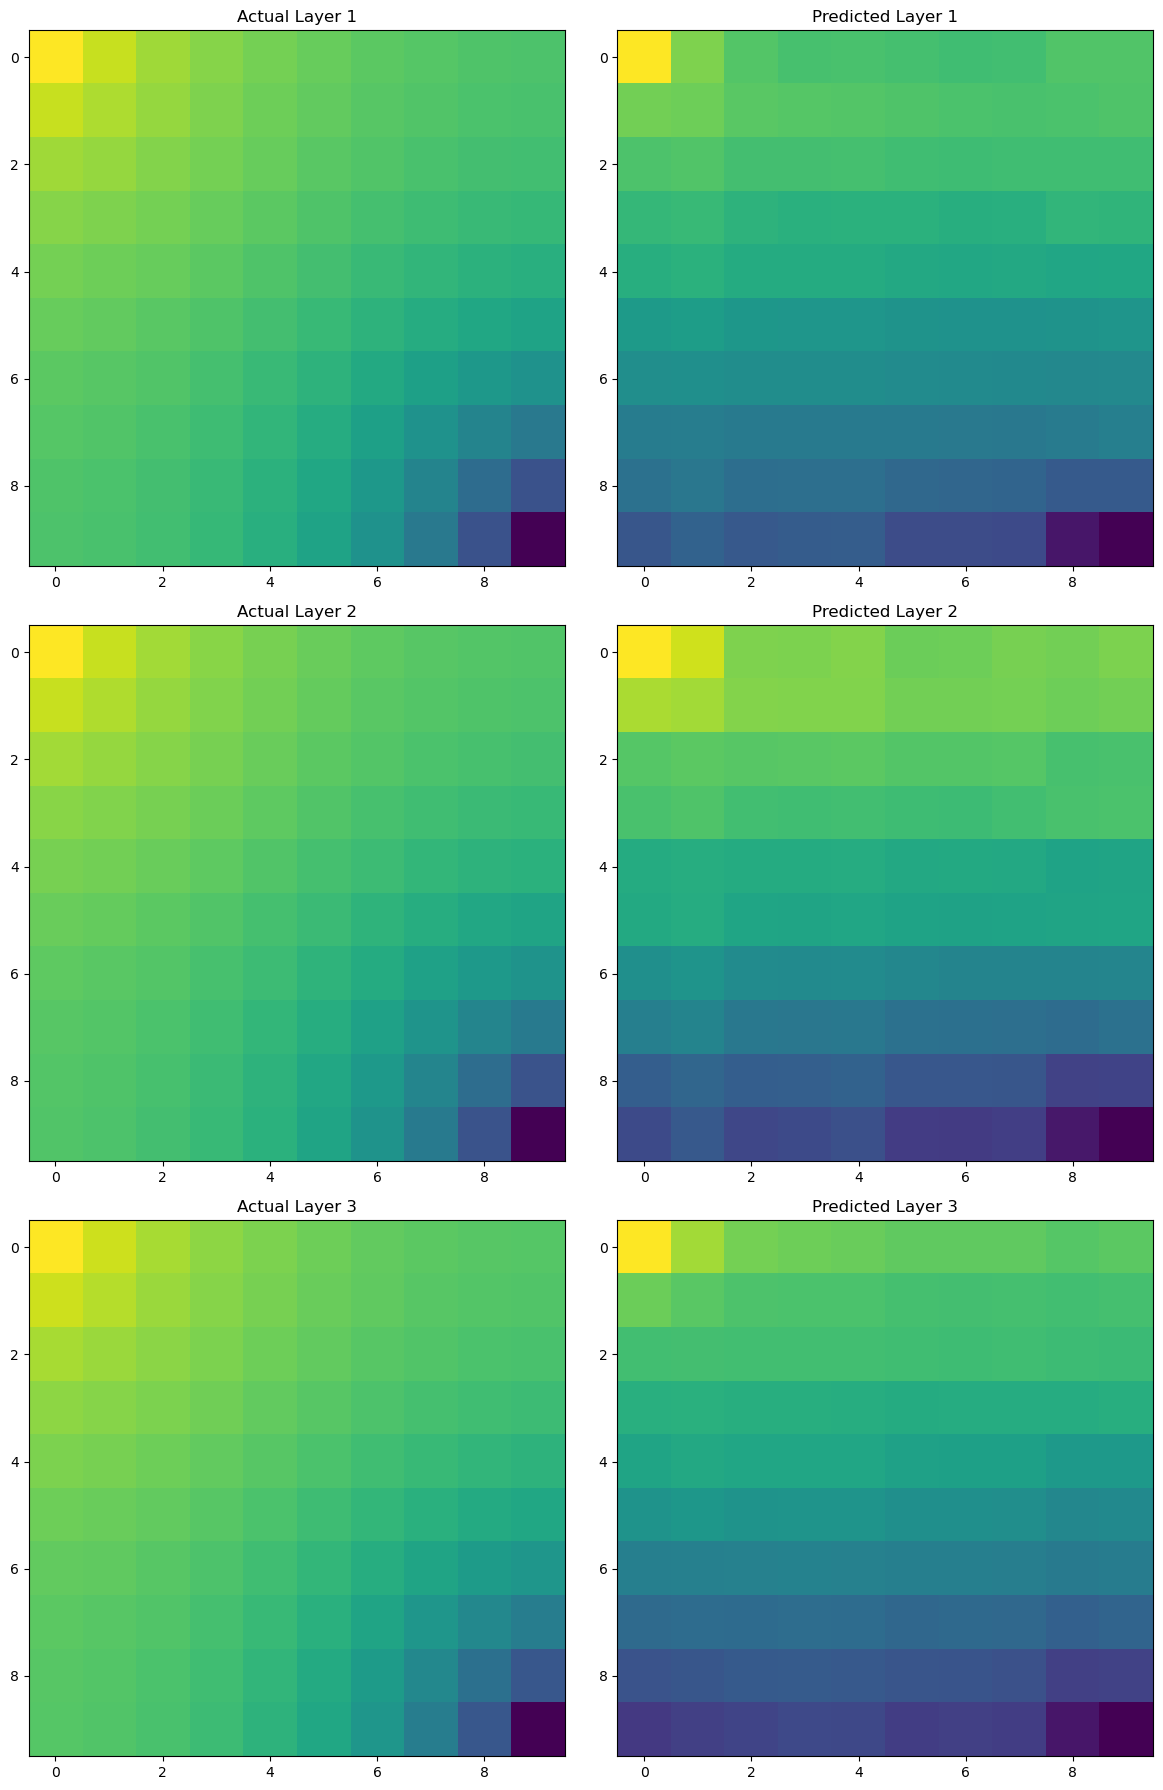

In [190]:
import matplotlib.pyplot as plt

# Setting up the figure and axis objects
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Looping through each layer to display
for i in range(y.shape[2]):
    # Actual values on the left
    axs[i, 0].imshow(y[:, :, i].cpu().detach().numpy(), cmap='viridis')
    axs[i, 0].set_title(f'Actual Layer {i+1}')
    
    # Predicted values on the right
    axs[i, 1].imshow(pred[:, :, i].cpu().detach().numpy(), cmap='viridis')
    axs[i, 1].set_title(f'Predicted Layer {i+1}')

plt.tight_layout()
plt.show()
